In [1]:
# Import main libraries
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from IPython.display import display

# Import necessary gates for QZE fix and basis measurement
from qiskit.circuit.library import XGate, ZGate, HGate

# Import noise model components
from qiskit_aer.noise import NoiseModel, pauli_error, depolarizing_error
import matplotlib.colors as mcolors

print("Libraries imported.")

/var/folders/x6/c44jk2f54jl2th8706q9sv500000gn/T/ipykernel_3441/2563307208.py:4: DeprecationWarning: Using Qiskit with Python 3.9 is deprecated as of the 2.1.0 release. Support for running Qiskit with Python 3.9 will be removed in the 2.3.0 release, which coincides with when Python 3.9 goes end of life.
  from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister


Libraries imported.


In [2]:
def get_alice_choices(n):
    """Generate Alice's random bits and bases."""
    bits = np.random.randint(2, size=n)
    bases = np.random.randint(2, size=n) # 0 for Z-basis, 1 for X-basis
    return bits, bases

def get_bob_choices(n):
    """Generate Bob's random bases."""
    bases = np.random.randint(2, size=n) # 0 for Z-basis, 1 for X-basis
    return bases

def sift_keys(alice_bases, bob_bases, alice_bits, bob_bits):
    """Sift the keys to keep only bits where bases matched."""
    sift_indices = np.where(alice_bases == bob_bases)[0]
    sifted_alice = alice_bits[sift_indices]
    sifted_bob = bob_bits[sift_indices]
    return sifted_alice, sifted_bob

def calculate_qber(alice_key, bob_key):
    """Calculates the Quantum Bit Error Rate."""
    if len(alice_key) == 0:
        return 0
    mismatches = np.sum(alice_key != bob_key)
    qber = mismatches / len(alice_key)
    return qber

print("Basic BB84 helper functions defined.")

Basic BB84 helper functions defined.


In [3]:
def get_aer_bit_flip_noise(p_noise):
    """Returns an Aer NoiseModel for Bit Flip (X) error applied to 'id'."""
    if p_noise <= 0: # Return None if no noise
        return None
    error = pauli_error([('X', p_noise), ('I', 1 - p_noise)])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['id'])
    return noise_model

def get_aer_phase_flip_noise(p_noise):
    """Returns an Aer NoiseModel for Phase Flip (Z) error applied to 'id'."""
    if p_noise <= 0:
        return None
    error = pauli_error([('Z', p_noise), ('I', 1 - p_noise)])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['id'])
    return noise_model

def get_aer_depolarizing_noise(p_noise):
    """Returns an Aer NoiseModel for Depolarizing error applied to 'id'."""
    if p_noise <= 0:
        return None
    error = depolarizing_error(p_noise, 1) # 1-qubit depolarizing error
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['id'])
    return noise_model

print("AerSimulator NoiseModel functions defined.")

AerSimulator NoiseModel functions defined.


In [4]:
def build_qze_bb84_circ_clean(alice_bit, alice_basis, bob_basis, n_zeno_steps):
    """
    Builds a 'clean' QZE-Enhanced BB84 circuit.
    For n_zeno_steps > 1, Zeno measurements are applied.
    For n_zeno_steps <= 1, it reverts to a single-channel standard BB84.
    """
    n_zeno_actual = max(0, n_zeno_steps) # Ensure non-negative
    
    qr = QuantumRegister(1, 'q')
    cr_zeno = ClassicalRegister(n_zeno_actual, 'c_zeno')
    cr_bob = ClassicalRegister(1, 'c_bob')
    
    # Handle n_zeno_steps=1 (Standard) case which doesn't need cr_zeno
    if n_zeno_steps <= 1:
        qc = QuantumCircuit(qr, cr_bob)
    else:
        qc = QuantumCircuit(qr, cr_zeno, cr_bob)

    # 1. Alice prepares her qubit
    if alice_bit == 1:
        qc.x(0)
    if alice_basis == 1: # X-basis
        qc.h(0)
    qc.barrier(label='Alice Prep')

    # 2. QZE/Channel Loop
    n_steps_effective = max(1, n_zeno_steps) # At least one ID gate for noise

    for i in range(n_steps_effective):
        # a) Placeholder for external noise
        qc.id(0)

        # b) Apply Zeno measurement if n_zeno_steps > 1
        if n_zeno_steps > 1:
            zeno_cbit = cr_zeno[i]
            
            if alice_basis == 1: # X-basis measurement
                qc.h(0)
            
            qc.measure(qr[0], zeno_cbit)

            # c) Reset and conditional X to restore measured state
            qc.reset(0)
            with qc.if_test((zeno_cbit, 1)):
                 qc.x(0)

            # d) Prepare for next step
            if alice_basis == 1: # Revert H if measured in X
                qc.h(0)

            if i < n_zeno_steps - 1:
                 qc.barrier() 
        
    # If n_zeno_steps == 0 or 1 (Standard BB84), we must add the single ID gate
    if n_zeno_steps <= 1:
        qc.id(0) # The single channel placeholder

    qc.barrier(label='Channel Done')

    # 3. Bob measures the qubit
    if bob_basis == 1: # X-basis
        qc.h(0)
    qc.measure(qr[0], cr_bob[0]) 

    return qc

print("QZE BB84 circuit builder defined.")

QZE BB84 circuit builder defined.


In [5]:
def run_qze_bb84_aer_noise(n_qubits, p_noise, n_zeno_steps, noise_type='bit_flip'):
    """Simulates the QZE-enhanced BB84 protocol using a clean circuit and Aer NoiseModel."""
    alice_bits, alice_bases = get_alice_choices(n_qubits)
    bob_bases = get_bob_choices(n_qubits)

    # --- Create Noise Model (Scaled) ---
    n_steps_for_noise = max(1, n_zeno_steps)
    p_step = p_noise / n_steps_for_noise if n_steps_for_noise > 0 else 0

    noise_model = None
    if p_step > 0:
        if noise_type == 'bit_flip':
            noise_model = get_aer_bit_flip_noise(p_step)
        elif noise_type == 'phase_flip':
            noise_model = get_aer_phase_flip_noise(p_step)
        else: # depolarizing
            noise_model = get_aer_depolarizing_noise(p_step)
    # --- End Noise Model Creation ---

    simulator = AerSimulator(noise_model=noise_model) if noise_model else AerSimulator()
    bob_bits = []

    for i in range(n_qubits):
        qc = build_qze_bb84_circ_clean(
            alice_bits[i], alice_bases[i], bob_bases[i], n_zeno_steps
        )
        
        job = simulator.run(qc, shots=1, memory=True)
        result = job.result()
        memory_str = result.get_memory()[0] 
        
        # Memory string is 'c_bob c_zeno'
        measured_bob_bit = int(memory_str.split(' ')[0]) 
        bob_bits.append(measured_bob_bit)

    bob_bits = np.array(bob_bits)
    sifted_alice, sifted_bob = sift_keys(alice_bases, bob_bases, alice_bits, bob_bits)
    qber = calculate_qber(sifted_alice, sifted_bob)
    sifted_key_length = len(sifted_alice)

    # Return QBER and Sifted Key Length
    return qber, sifted_key_length

print("QZE BB84 simulation function (Aer Noise Model) defined.")

QZE BB84 simulation function (Aer Noise Model) defined.


--- QZE vs. Standard Comparison (p_noise=0.25, N_qubits=1024) ---
Noise Type: bit_flip

  Standard BB84 (N=1 step):
    Total Qubits Sent: 1024
    Sifted Key Length: 494 (approx. 48.2%)
    QBER: 0.1903

  QZE-Enhanced (N=10 steps):
    Total Qubits Sent: 1024
    Sifted Key Length: 507 (approx. 49.5%)
    QBER: 0.0809



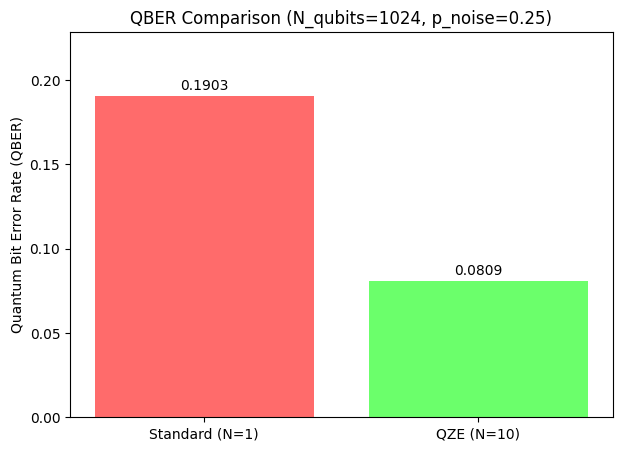

In [6]:
# --- Simulation Parameters ---
N_QUBITS_ANALYSIS = 1024
P_FIXED_NOISE = 0.25 # A high noise level for comparison
N_ZENO_STEPS_ANALYSIS = 10
NOISE_TYPE_ANALYSIS = 'bit_flip' # QZE is optimized for this

print(f"--- QZE vs. Standard Comparison (p_noise={P_FIXED_NOISE}, N_qubits={N_QUBITS_ANALYSIS}) ---")
print(f"Noise Type: {NOISE_TYPE_ANALYSIS}\n")

# 1. Standard Protocol (N=1 Zeno step is equivalent)
qber_std, len_std = run_qze_bb84_aer_noise(
    N_QUBITS_ANALYSIS, 
    P_FIXED_NOISE, 
    1, 
    noise_type=NOISE_TYPE_ANALYSIS
)
print(f"  Standard BB84 (N=1 step):")
print(f"    Total Qubits Sent: {N_QUBITS_ANALYSIS}")
print(f"    Sifted Key Length: {len_std} (approx. {len_std/N_QUBITS_ANALYSIS * 100:.1f}%)")
print(f"    QBER: {qber_std:.4f}\n")


# 2. QZE-Enhanced Protocol
qber_qze, len_qze = run_qze_bb84_aer_noise(
    N_QUBITS_ANALYSIS, 
    P_FIXED_NOISE, 
    N_ZENO_STEPS_ANALYSIS, 
    noise_type=NOISE_TYPE_ANALYSIS
)
print(f"  QZE-Enhanced (N={N_ZENO_STEPS_ANALYSIS} steps):")
print(f"    Total Qubits Sent: {N_QUBITS_ANALYSIS}")
print(f"    Sifted Key Length: {len_qze} (approx. {len_qze/N_QUBITS_ANALYSIS * 100:.1f}%)")
print(f"    QBER: {qber_qze:.4f}\n")

# --- Plot the bar graph comparison ---
plt.figure(figsize=(7, 5))
labels = [f'Standard (N=1)', f'QZE (N={N_ZENO_STEPS_ANALYSIS})']
qbers = [qber_std, qber_qze]
colors = ['#FF6B6B', '#6BFF6B'] # Red, Green

bars = plt.bar(labels, qbers, color=colors)
plt.ylabel('Quantum Bit Error Rate (QBER)')
plt.title(f'QBER Comparison (N_qubits={N_QUBITS_ANALYSIS}, p_noise={P_FIXED_NOISE})')
plt.ylim(top=max(qbers)*1.2) # Set y-limit slightly above max QBER

# Add QBER values on top of bars
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.002, f'{yval:.4f}', ha='center', va='bottom')

plt.show()

--- QZE vs. Standard Comparison (p_noise=0.25, N_qubits=2048) ---
Noise Type: bit_flip

  Standard BB84 (N=1 step):
    Total Qubits Sent: 2048
    Sifted Key Length: 1048 (approx. 51.2%)
    QBER: 0.1832

  QZE-Enhanced (N=10 steps):
    Total Qubits Sent: 2048
    Sifted Key Length: 1038 (approx. 50.7%)
    QBER: 0.1118



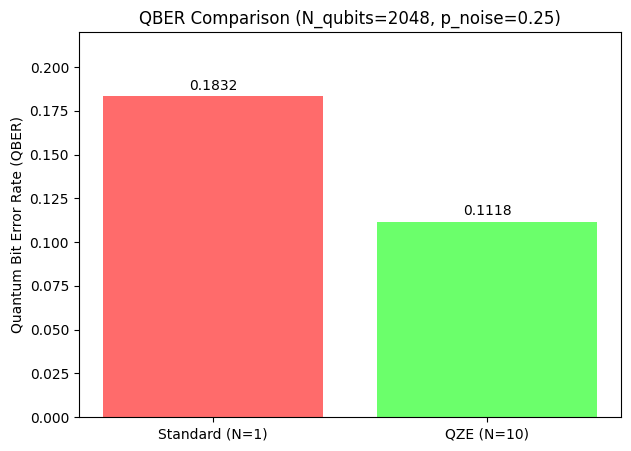

In [7]:
# --- Simulation Parameters ---
N_QUBITS_ANALYSIS = 2048
P_FIXED_NOISE = 0.25 # A high noise level for comparison
N_ZENO_STEPS_ANALYSIS = 10
NOISE_TYPE_ANALYSIS = 'bit_flip' # QZE is optimized for this

print(f"--- QZE vs. Standard Comparison (p_noise={P_FIXED_NOISE}, N_qubits={N_QUBITS_ANALYSIS}) ---")
print(f"Noise Type: {NOISE_TYPE_ANALYSIS}\n")

# 1. Standard Protocol (N=1 Zeno step is equivalent)
qber_std, len_std = run_qze_bb84_aer_noise(
    N_QUBITS_ANALYSIS, 
    P_FIXED_NOISE, 
    1, 
    noise_type=NOISE_TYPE_ANALYSIS
)
print(f"  Standard BB84 (N=1 step):")
print(f"    Total Qubits Sent: {N_QUBITS_ANALYSIS}")
print(f"    Sifted Key Length: {len_std} (approx. {len_std/N_QUBITS_ANALYSIS * 100:.1f}%)")
print(f"    QBER: {qber_std:.4f}\n")


# 2. QZE-Enhanced Protocol
qber_qze, len_qze = run_qze_bb84_aer_noise(
    N_QUBITS_ANALYSIS, 
    P_FIXED_NOISE, 
    N_ZENO_STEPS_ANALYSIS, 
    noise_type=NOISE_TYPE_ANALYSIS
)
print(f"  QZE-Enhanced (N={N_ZENO_STEPS_ANALYSIS} steps):")
print(f"    Total Qubits Sent: {N_QUBITS_ANALYSIS}")
print(f"    Sifted Key Length: {len_qze} (approx. {len_qze/N_QUBITS_ANALYSIS * 100:.1f}%)")
print(f"    QBER: {qber_qze:.4f}\n")

# --- Plot the bar graph comparison ---
plt.figure(figsize=(7, 5))
labels = [f'Standard (N=1)', f'QZE (N={N_ZENO_STEPS_ANALYSIS})']
qbers = [qber_std, qber_qze]
colors = ['#FF6B6B', '#6BFF6B'] # Red, Green

bars = plt.bar(labels, qbers, color=colors)
plt.ylabel('Quantum Bit Error Rate (QBER)')
plt.title(f'QBER Comparison (N_qubits={N_QUBITS_ANALYSIS}, p_noise={P_FIXED_NOISE})')
plt.ylim(top=max(qbers)*1.2) # Set y-limit slightly above max QBER

# Add QBER values on top of bars
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.002, f'{yval:.4f}', ha='center', va='bottom')

plt.show()

Running QBER stability analysis (p_noise=0.25, N_steps=10) vs. Qubit Count...
  Simulating for N_qubits = 100...
  Simulating for N_qubits = 545...
  Simulating for N_qubits = 990...
  Simulating for N_qubits = 1436...
  Simulating for N_qubits = 1881...
  Simulating for N_qubits = 2327...
  Simulating for N_qubits = 2772...
  Simulating for N_qubits = 3218...
  Simulating for N_qubits = 3663...
  Simulating for N_qubits = 4109...
  Simulating for N_qubits = 4554...
  Simulating for N_qubits = 5000...
Simulations complete. Plotting...


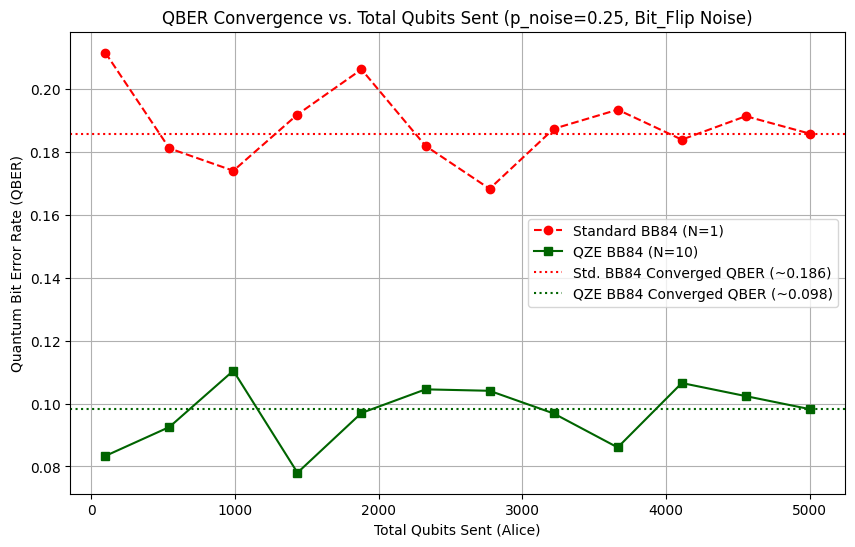

In [9]:
# --- Simulation Parameters ---
# Vary the total number of qubits sent
qubit_range = np.linspace(100, 5000, 12, dtype=int) 

# Use the fixed noise level and Zeno steps defined in Cell 1
p_noise_fixed = 0.25    # 0.25
n_zeno_qze = 10      # 10
n_zeno_std = 1                       # Standard BB84
noise_type = 'bit_flip'              # Noise type QZE is most effective against

# Data structures to store results
qber_results_std = []
qber_results_qze = []

print(f"Running QBER stability analysis (p_noise={p_noise_fixed}, N_steps={n_zeno_qze}) vs. Qubit Count...")

# --- Simulation Loop ---
for n_qubits in qubit_range:
    print(f"  Simulating for N_qubits = {n_qubits}...")
    
    # Run Standard BB84 (N=1)
    q_std, _ = run_qze_bb84_aer_noise(
        n_qubits, 
        p_noise_fixed, 
        n_zeno_std, 
        noise_type=noise_type
    )
    qber_results_std.append(q_std)

    # Run QZE-BB84 (N=10)
    q_qze, _ = run_qze_bb84_aer_noise(
        n_qubits, 
        p_noise_fixed, 
        n_zeno_qze, 
        noise_type=noise_type
    )
    qber_results_qze.append(q_qze)

print("Simulations complete. Plotting...")

# --- Plotting ---
plt.figure(figsize=(10, 6))

plt.plot(qubit_range, qber_results_std, 'o--', color='red', label=f'Standard BB84 (N=1)')
plt.plot(qubit_range, qber_results_qze, 's-', color='darkgreen', label=f'QZE BB84 (N={n_zeno_qze})')

# Add horizontal lines for the expected "true" QBER (taken from the last, most accurate simulation point)
if len(qber_results_std) > 0:
    plt.axhline(y=qber_results_std[-1], color='red', linestyle=':', label=f'Std. BB84 Converged QBER (~{qber_results_std[-1]:.3f})')
if len(qber_results_qze) > 0:
    plt.axhline(y=qber_results_qze[-1], color='darkgreen', linestyle=':', label=f'QZE BB84 Converged QBER (~{qber_results_qze[-1]:.3f})')


plt.xlabel('Total Qubits Sent (Alice)')
plt.ylabel('Quantum Bit Error Rate (QBER)')
plt.title(f'QBER Convergence vs. Total Qubits Sent (p_noise={p_noise_fixed}, {noise_type.title()} Noise)')
plt.legend()
plt.grid(True)
plt.show()

Running simulation to break down error source for N_qubits=1024...

Simulations complete. Plotting breakdown...


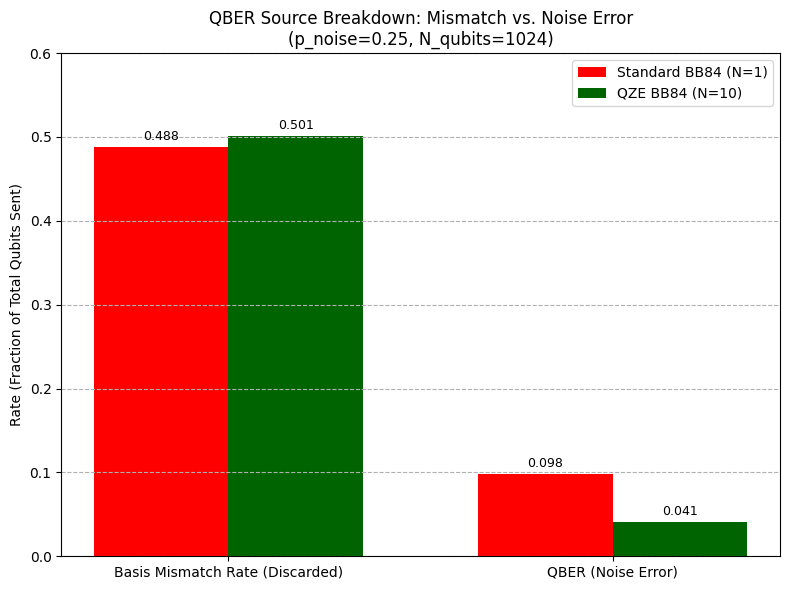

In [12]:
# --- Simulation Parameters for Comparison ---
N_QUBITS_COMPARE = 1024  # Increased for better statistical significance
P_NOISE_COMPARE = 0.25   # Fixed high noise level
N_ZENO_QZE_COMPARE = 10  # Fixed QZE steps
NOISE_TYPE_COMPARE = 'bit_flip'

print(f"Running simulation to break down error source for N_qubits={N_QUBITS_COMPARE}...")

# 1. --- Run Standard BB84 (N=1) ---
qber_std, len_std = run_qze_bb84_aer_noise(
    N_QUBITS_COMPARE, 
    P_NOISE_COMPARE, 
    1, 
    noise_type=NOISE_TYPE_COMPARE
)

# Basis Mismatch Rate (fraction of total qubits sent)
# Since ~50% of bases are mismatched, this rate should be close to 0.5
mismatch_rate_std = 1 - (len_std / N_QUBITS_COMPARE)

# 2. --- Run QZE-BB84 (N=10) ---
qber_qze, len_qze = run_qze_bb84_aer_noise(
    N_QUBITS_COMPARE, 
    P_NOISE_COMPARE, 
    N_ZENO_QZE_COMPARE, 
    noise_type=NOISE_TYPE_COMPARE
)

# Basis Mismatch Rate (should also be close to 0.5)
mismatch_rate_qze = 1 - (len_qze / N_QUBITS_COMPARE)

print("\nSimulations complete. Plotting breakdown...")

# --- Plotting Bar Chart Comparison ---
labels = ['Basis Mismatch Rate (Discarded)', 'QBER (Noise Error)']
# Normalize QBER by the total number of qubits sent for a true comparison in the bar chart
# Note: QBER is already normalized by the sifted key length, so we normalize the *error count* # by the total qubits sent to plot it on the same scale as the mismatch rate.
qber_count_std = qber_std * len_std
qber_rate_std = qber_count_std / N_QUBITS_COMPARE

qber_count_qze = qber_qze * len_qze
qber_rate_qze = qber_count_qze / N_QUBITS_COMPARE


std_values = [mismatch_rate_std, qber_rate_std]
qze_values = [mismatch_rate_qze, qber_rate_qze]

x = np.arange(len(labels)) 
width = 0.35  

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, std_values, width, label='Standard BB84 (N=1)', color='red')
rects2 = ax.bar(x + width/2, qze_values, width, label=f'QZE BB84 (N={N_ZENO_QZE_COMPARE})', color='darkgreen')

# Add some text for labels and titles
ax.set_ylabel('Rate (Fraction of Total Qubits Sent)')
ax.set_title(f'QBER Source Breakdown: Mismatch vs. Noise Error\n(p_noise={P_NOISE_COMPARE}, N_qubits={N_QUBITS_COMPARE})')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', linestyle='--')
ax.set_ylim(0, 0.6) # Set y-limit to clearly show the ~0.5 mismatch rate

# Function to attach a label to each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()